In [ ]:
import cv2
import dlib
import numpy as np
import pandas as pd
import os
import joblib

# Thư viện cho Machine Learning & Deep Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
# --- CẤU HÌNH ---
EMOTION_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
TRAIN_CSV = "dataset_csv/fer2013_train.csv" 
TEST_CSV  = "dataset_csv/fer2013_test.csv"
DLIB_MODEL_PATH = "model/shape_predictor_68_face_landmarks.dat"
IMG_SIZE = (48, 48) # Kích thước ảnh đầu vào cho CNN

In [4]:
# Kiểm tra file Dlib
if not os.path.exists(DLIB_MODEL_PATH):
    print(f"LỖI: Thiếu file {DLIB_MODEL_PATH}")
    

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(DLIB_MODEL_PATH)

In [5]:
def center_scale_landmarks(X):
    """Chuẩn hóa landmark về tâm và scale"""
    X_cs = []
    if X.ndim == 1: X = X.reshape(1, -1)
    for s in X:
        xs, ys = s[::2], s[1::2]
        mean_x, mean_y = xs.mean(), ys.mean()
        scale = max(xs.max()-xs.min(), ys.max()-ys.min())
        if scale == 0: scale = 1
        X_cs.append(np.column_stack([(xs-mean_x)/scale, (ys-mean_y)/scale]).flatten())
    return np.array(X_cs)

In [6]:
def warp_face(img, src_lms, mean_lms, size=(48,48)):
    """Warp khuôn mặt về mean shape để đưa vào CNN"""
    src_pts = src_lms.reshape(-1,2) * size[0]
    dst_pts = mean_lms.reshape(-1,2) * size[0]

    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    
    # Resize tạm để warp tốt hơn
    if img_gray.shape[0] < size[0]:
        img_gray = cv2.resize(img_gray, size)

    # Biến đổi Affine
    M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    if M is not None:
        warped = cv2.warpAffine(img_gray, M, size)
    else:
        warped = cv2.resize(img_gray, size)
        
    # Chuẩn hóa về [0, 1] và reshape cho CNN (48, 48, 1)
    warped = warped.astype('float32') / 255.0
    return np.expand_dims(warped, axis=-1)


In [7]:
def create_hybrid_model(shape_input_dim, num_classes=7):
    # Nhánh 1: CNN cho ảnh (Texture/Appearance)
    input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), name="img_input")
    
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Dropout(0.25)(x1)

    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Dropout(0.25)(x1)
    
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Nhánh 2: Dense cho Shape Landmark (Đã qua PCA)
    input_shape = Input(shape=(shape_input_dim,), name="shape_input")
    x2 = Dense(64, activation='relu')(input_shape)
    x2 = Dense(32, activation='relu')(x2)
    
    # Kết hợp (Fusion)
    combined = Concatenate()([x1, x2])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)
    
    model = Model(inputs=[input_img, input_shape], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


In [9]:
def load_data(csv_path):
    # --- ĐÃ SỬA LỖI TẠI ĐÂY ---
    # Thêm header=None và dùng iloc để lấy cột theo vị trí
    df = pd.read_csv(csv_path, header=None)
    
    # Cột 0: Path, Cột 2: Label, Cột 4+: Landmarks
    paths = df.iloc[:, 0].values
    y = df.iloc[:, 2].values
    X_lms = df.iloc[:, 4:].values.astype(np.float32)
    
    return paths, X_lms, y

In [10]:
if os.path.exists("model/hybrid_model.h5"):
    print(">>> Load Model Hybrid đã train...")
    model = load_model("model/hybrid_model.h5")
    pca_shape = joblib.load("model/shape_pca.pkl")
    scaler = joblib.load("model/shape_scaler.pkl")
    mean_shape = joblib.load("model/mean_shape.pkl")
else:
    print(">>> Bắt đầu xử lý dữ liệu để Train...")
    
    paths_train, X_lms_train, y_train = load_data(TRAIN_CSV)
    paths_test, X_lms_test, y_test = load_data(TEST_CSV)

    # 1. Train PCA cho Shape (AAM part)
    print(" - Training Shape PCA...")
    X_shape_train_raw = center_scale_landmarks(X_lms_train)
    pca_shape = PCA(n_components=0.99) # Giữ 99% thông tin hình dáng
    X_shape_train_pca = pca_shape.fit_transform(X_shape_train_raw)
    
    # Scale dữ liệu Shape trước khi đưa vào Neural Net
    scaler = StandardScaler()
    X_shape_train_pca = scaler.fit_transform(X_shape_train_pca)

    # Tính Mean Shape để Warp ảnh
    mean_shape_raw = X_shape_train_raw.mean(axis=0)
    mean_shape = (mean_shape_raw - mean_shape_raw.min()) / (mean_shape_raw.max() - mean_shape_raw.min())

    # 2. Chuẩn bị ảnh cho CNN (Warping)
    print(" - Warping Images for CNN (Bước này hơi lâu)...")
    def prepare_hybrid_data(paths, lms_raw, shape_pca_model, scaler_model):
        X_img_list = []
        X_shape_list = []
        y_list = []
        
        # Xử lý PCA cho shape trước
        lms_cs = center_scale_landmarks(lms_raw)
        shapes_pca = shape_pca_model.transform(lms_cs)
        shapes_scaled = scaler_model.transform(shapes_pca)

        for i, path in enumerate(paths):
            try:
                img = cv2.imread(path)
                if img is None: continue
                
                # Normalize landmark [0,1] để warp (FER2013 gốc 48x48)
                lms_norm = lms_raw[i] / 48.0
                
                # Tạo ảnh warp (48, 48, 1)
                warped = warp_face(img, lms_norm, mean_shape, IMG_SIZE)
                
                X_img_list.append(warped)
                X_shape_list.append(shapes_scaled[i])
                y_list.append(y_train[i] if len(paths) == len(y_train) else y_test[i])
            except:
                continue
        
        return np.array(X_img_list), np.array(X_shape_list), np.array(y_list)

    # Chuẩn bị dữ liệu Train
    X_img_train, X_shape_train, y_train_clean = prepare_hybrid_data(paths_train, X_lms_train, pca_shape, scaler)
    # Chuẩn bị dữ liệu Test (Để validate)
    X_img_test, X_shape_test, y_test_clean = prepare_hybrid_data(paths_test, X_lms_test, pca_shape, scaler)

    print(f" - Dữ liệu Train hợp lệ: {len(X_img_train)} mẫu")
    
    # 3. Train Model
    print(">>> Khởi tạo và Train Hybrid Model...")
    model = create_hybrid_model(shape_input_dim=X_shape_train.shape[1])
    
    model.fit(
        x=[X_img_train, X_shape_train],
        y=y_train_clean,
        validation_data=([X_img_test, X_shape_test], y_test_clean),
        epochs=15, 
        batch_size=64
    )
    
    # 4. Lưu Model
    if not os.path.exists("model"): os.makedirs("model")
    model.save("model/hybrid_model.h5")
    joblib.dump(pca_shape, "model/shape_pca.pkl")
    joblib.dump(scaler, "model/shape_scaler.pkl")
    joblib.dump(mean_shape, "model/mean_shape.pkl")
    print(">>> Đã lưu model thành công!")

>>> Bắt đầu xử lý dữ liệu để Train...
 - Training Shape PCA...
 - Warping Images for CNN (Bước này hơi lâu)...
 - Dữ liệu Train hợp lệ: 26530 mẫu
>>> Khởi tạo và Train Hybrid Model...
Epoch 1/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.2771 - loss: 1.9056 - val_accuracy: 0.2860 - val_loss: 4.1220
Epoch 2/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.4272 - loss: 1.4562 - val_accuracy: 0.5244 - val_loss: 1.2399
Epoch 3/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.5040 - loss: 1.3005 - val_accuracy: 0.5262 - val_loss: 1.2380
Epoch 4/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5304 - loss: 1.2160 - val_accuracy: 0.5623 - val_loss: 1.1515
Epoch 5/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.5567 - loss: 1.1554 - val_accuracy: 0.5783 - val_loss: 1.1257
Epoch 6/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.5833 - loss: 1.0979 - val_accuracy: 0.5739 - val_loss: 1.1108
Epoch 7/15
415/415 ━━━━━━━━━━━━━━━━━

>>> Đã lưu model thành công!


In [11]:
# --- INFERENCE (WEB CAM & IMAGE) ---

def predict_hybrid(img, lms_raw):
    """Hàm dự đoán dùng chung cho webcam và ảnh"""
    # 1. Xử lý Shape
    lms_cs = center_scale_landmarks(lms_raw)
    shape_feat = pca_shape.transform(lms_cs)
    shape_feat = scaler.transform(shape_feat) # (1, n_pca)
    
    # 2. Xử lý Ảnh (Warp -> CNN Input)
    h, w = img.shape[:2]
    lms_norm = lms_raw.reshape(-1, 2).astype(np.float32)
    # Scale landmark về [0,1]
    lms_norm[:, 0] /= w
    lms_norm[:, 1] /= h
    lms_norm = lms_norm.flatten()
    
    img_input = warp_face(img, lms_norm, mean_shape, IMG_SIZE)
    img_input = np.expand_dims(img_input, axis=0) # (1, 48, 48, 1)
    
    # 3. Predict
    proba = model.predict([img_input, shape_feat], verbose=0)[0]
    idx = np.argmax(proba)
    return EMOTION_LABELS[idx], proba[idx]


In [44]:
def webcam_demo():
    cap = cv2.VideoCapture(0)
    print("\n>>> Đang chạy Webcam Hybrid... Nhấn ESC để thoát.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # 1. Resize
        frame_small = cv2.resize(frame, (640, 480))

        # 2. Chuyển sang Gray
        gray = cv2.cvtColor(frame_small, cv2.COLOR_BGR2GRAY)

        # 3. XỬ LÝ KHẮC PHỤC LỖI TUYỆT ĐỐI
        # Dlib đôi khi ghét mảng 3D (H, W, 1), nó chỉ thích 2D (H, W)
        if len(gray.shape) == 3:
            gray = gray[:, :, 0] # Lấy kênh đầu tiên để ép về 2D
        
        # Tạo mảng mới tinh, độc lập hoàn toàn
        input_dlib = np.array(gray, dtype=np.uint8, copy=True)

        try:
            # 4. Detect (Chỉ gửi ảnh xám 2D)
            rects = detector(input_dlib, 0)
            
            # Nếu chạy qua được dòng trên nghĩa là đã thành công
            for rect in rects:
                # Predict landmark
                shape = predictor(input_dlib, rect)

                lms = np.array(
                    [[shape.part(i).x, shape.part(i).y] for i in range(68)],
                    dtype=np.int32
                ).flatten()

                # Vẽ landmark (vẽ lên ảnh màu frame_small để nhìn cho đẹp)
                for i in range(0, 136, 2):
                    cv2.circle(frame_small, (lms[i], lms[i+1]), 1, (0, 255, 255), -1)

                try:
                    # Predict Emotion
                    emotion, conf = predict_hybrid(frame_small, lms)

                    # Vẽ box
                    x, y, w, h = rect.left(), rect.top(), rect.width(), rect.height()
                    color = (0, 255, 0) if emotion in ['happy', 'neutral'] else (0, 0, 255)

                    cv2.rectangle(frame_small, (x, y), (x+w, y+h), color, 2)
                    cv2.putText(frame_small, f"{emotion} {conf:.2f}", (x, y-10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                except:
                    pass

        except RuntimeError as e:
            print(f"Vẫn lỗi Dlib: {e}")
            break

        cv2.imshow("Hybrid CNN + AAM", frame_small)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()


   BẮT ĐẦU ĐÁNH GIÁ MODEL TRÊN TẬP TEST
>>> Đang xử lý dữ liệu test (Warping & PCA)...
>>> Đang chạy dự đoán...
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

>>> ĐỘ CHÍNH XÁC (ACCURACY): 61.23%

>>> BÁO CÁO CHI TIẾT:
              precision    recall  f1-score   support

       angry       0.52      0.53      0.53       835
     disgust       0.76      0.36      0.49        97
        fear       0.45      0.36      0.40       933
       happy       0.81      0.85      0.83      1713
     neutral       0.55      0.57      0.56      1181
         sad       0.44      0.51      0.47      1094
    surprise       0.78      0.73      0.75       779

    accuracy                           0.61      6632
   macro avg       0.62      0.56      0.58      6632
weighted avg       0.61      0.61      0.61      6632



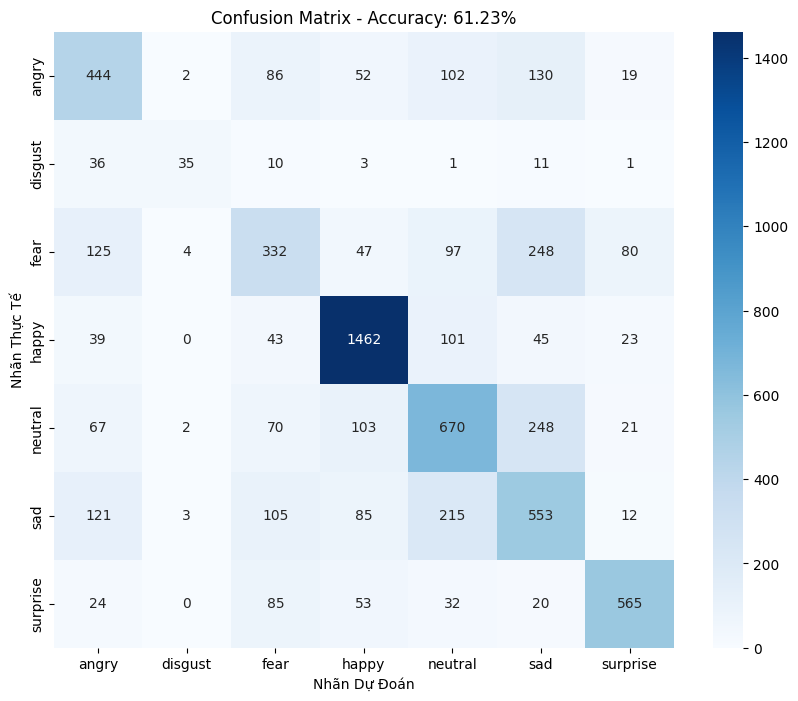

In [18]:
# --- THÊM PHẦN NÀY ĐỂ ĐÁNH GIÁ MODEL ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance():
    print("\n" + "="*40)
    print("   BẮT ĐẦU ĐÁNH GIÁ MODEL TRÊN TẬP TEST")
    print("="*40)
    
    # 1. Load lại dữ liệu Test (Để đảm bảo có dữ liệu dù là Train mới hay Load model)
    paths_test, X_lms_test, y_test = load_data(TEST_CSV)
    
    # 2. Xử lý dữ liệu Test theo đúng quy trình của Hybrid Model
    print(">>> Đang xử lý dữ liệu test (Warping & PCA)...")
    X_img_test, X_shape_test, y_test_clean = prepare_hybrid_data(paths_test, X_lms_test, pca_shape, scaler)
    
    # 3. Dự đoán
    print(">>> Đang chạy dự đoán...")
    y_pred_probs = model.predict([X_img_test, X_shape_test], verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 4. Tính toán Accuracy
    acc = accuracy_score(y_test_clean, y_pred)
    print(f"\n>>> ĐỘ CHÍNH XÁC (ACCURACY): {acc * 100:.2f}%")
    
    # 5. In báo cáo chi tiết (Precision, Recall, F1-Score từng lớp)
    print("\n>>> BÁO CÁO CHI TIẾT:")
    print(classification_report(y_test_clean, y_pred, target_names=EMOTION_LABELS))
    
    # 6. Vẽ Ma trận nhầm lẫn (Confusion Matrix)
    try:
        cm = confusion_matrix(y_test_clean, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS)
        plt.title(f'Confusion Matrix - Accuracy: {acc*100:.2f}%')
        plt.ylabel('Nhãn Thực Tế')
        plt.xlabel('Nhãn Dự Đoán')
        plt.show()
    except Exception as e:
        print("Không thể vẽ biểu đồ (có thể do thiếu thư viện matplotlib/seaborn).")

# Gọi hàm đánh giá ngay sau khi load/train xong
evaluate_model_performance()

In [45]:
if __name__ == "__main__":
    # Chỉ chạy webcam sau khi đã train xong
    if os.path.exists("model/hybrid_model.h5"):
        webcam_demo()


>>> Đang chạy Webcam Hybrid... Nhấn ESC để thoát.
Vẫn lỗi Dlib: Unsupported image type, must be 8bit gray or RGB image.
